How many galaxies do we have CO observations for?

In [1]:
from astropy.table import Table

import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from dark_matter_mass_v1 import rot_fit_BB

In [2]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

# Data

In [10]:
#data_filename = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_SK_H2_v6.txt'
data_filename = '../../../data/kias1033_5_MPAJHU_ZdustOS-MartiniN2O2_HI100_H2_NSAv012_CMDJan2020.txt'

data = Table.read(data_filename, format='ascii.commented_header')

In [4]:
'''
################################################################################
# Calculate the velocity at R90, Rmax
#-------------------------------------------------------------------------------
# Convert r from arcsec to kpc
#-------------------------------------------------------------------------------
dist_to_galaxy_Mpc = c*data['NSA_redshift']/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

data['R90_kpc'] = dist_to_galaxy_kpc*np.tan(data['NSA_elpetro_th90']*(1./60)*(1./60)*(np.pi/180))
#-------------------------------------------------------------------------------

data['V90_kms'] = rot_fit_BB(data['R90_kpc'], 
                             [data['Vmax_map'], 
                              data['Rturn_map'], 
                              data['alpha_map']])

data['VRmax_kms'] = rot_fit_BB(data['Rmax_map'], 
                               [data['Vmax_map'], 
                                data['Rturn_map'], 
                                data['alpha_map']])
################################################################################
''';

## Calculate mass ratios

In [6]:
'''
data['M90_Mdisk_ratio'] = 10**(data['M90_map'] - data['M90_disk_map'])

data['M90_MdiskHI_ratio'] = 10**data['M90_map']/(10**data['M90_disk_map'] + 10**data['logHI'])

data['M90_vis'] = np.log10(10**data['M90_disk_map'] + 10**data['logHI'])
''';

## Remove galaxies with bad velocity map fits

In [7]:
"""
bad_boolean = np.logical_or.reduce([np.isnan(data['M90_map']), 
                                    np.isnan(data['M90_disk_map']), 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998, 
                                    #data['V90_kms']/data['Vmax_map'] < 0.9, 
                                    (data['Tidal'] & (data['DL_merge'] > 0.97)), 
                                    data['map_frac_unmasked'] < 0.05, 
                                    (data['map_frac_unmasked'] > 0.13) & (data['DRP_map_smoothness'] > 1.96), 
                                    (data['map_frac_unmasked'] > 0.07) & (data['DRP_map_smoothness'] > 2.9), 
                                    (data['map_frac_unmasked'] > -0.0638*data['DRP_map_smoothness'] + 0.255) & (data['DRP_map_smoothness'] > 1.96), 
                                    data['M90_Mdisk_ratio'] > 1050])

good_galaxies = data[~bad_boolean]

'''
bad_boolean = np.logical_or.reduce([data['M90_map'] == -99, 
                                    data['M90_disk_map'] == -99, 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998])

good_galaxies = data[~bad_boolean]
'''
"""
#print(len(good_galaxies))
print(len(data))


707817


## Pull out those objects with H$_2$ masses

In [11]:
#H2_boolean = np.isnan(good_galaxies['logH2'])
H2_boolean = np.isnan(data['logH2'])

#goodH2_galaxies = good_galaxies[~H2_boolean]
goodH2_galaxies = data[~H2_boolean]

print(len(goodH2_galaxies), np.sum(goodH2_galaxies['logH2'] > 0))

725 531


## Pull out those objects with HI masses

In [12]:
#HI_boolean = np.logical_or(good_galaxies['logHI'] == -99, good_galaxies['logHI'] == -999)
HI_boolean = np.logical_or(np.isnan(goodH2_galaxies['logHI']), 
                           goodH2_galaxies['logHI'] == -999)

goodH2HI_galaxies = goodH2_galaxies[~HI_boolean]

print(len(goodH2HI_galaxies))

261


# Distribution of H$_2$ masses

<IPython.core.display.Javascript object>


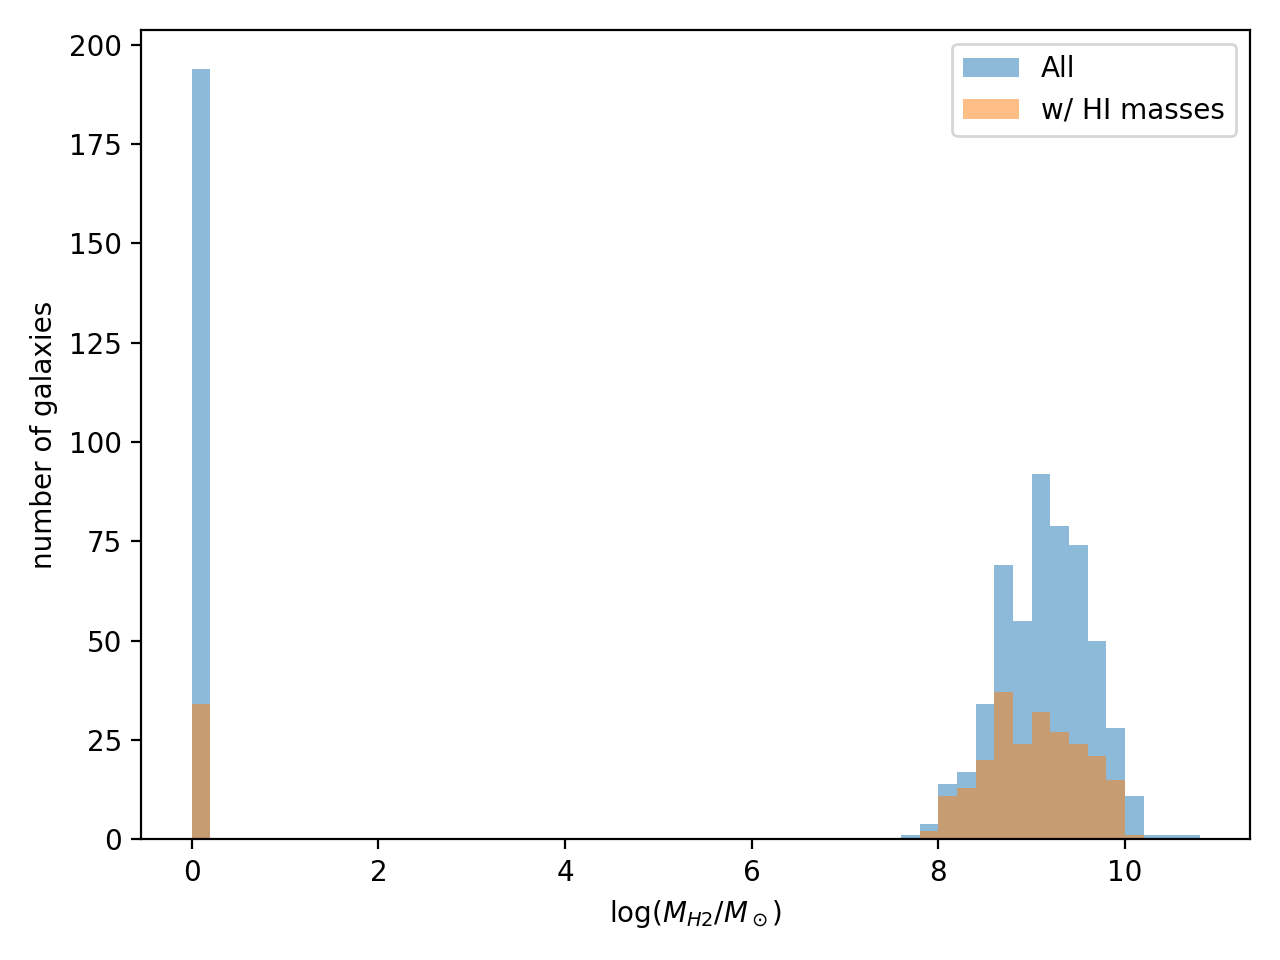

In [16]:
plt.figure(tight_layout=True)

H2_bins = np.arange(0,11,0.2)

plt.hist(data['logH2'], bins=H2_bins, alpha=0.5, label='All')
#plt.hist(good_galaxies['logH2'], bins=H2_bins, alpha=0.5, label='Good fits')
plt.hist(goodH2HI_galaxies['logH2'], bins=H2_bins, alpha=0.5, label='w/ HI masses')

plt.xlabel(r'log($M_{H2}/M_\odot$)')
plt.ylabel('number of galaxies')

plt.legend();